In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [1]:
import os
import pandas as pd
import json

# Retrieve data
___
Sourced from Golden Cheetah Open Data Project

In [78]:
if 'apple' in os.environ['BUILD']:
    root_dir = '../gc_opendata-samples'
else:
    root_dir = 'E:\gc_opendata'

In [167]:
class open_dataset(object):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.athlete_ids = self.get_athlete_ids()
    def get_athlete_ids(self):
        for a,b,c in os.walk(self.root_dir):
            athletes = b
            athletes.remove('INDEX') if 'INDEX' in athletes else 0
            break
        return athletes

    def get_athlete_summary(self, athlete_id, make_float = True):
        ath_summary_path = self._athlete_summary_path(athlete_id=athlete_id)
        with open(ath_summary_path, 'r') as f:
            summary_json = f.read()
        f.close()
        rides = json.loads(summary_json)['RIDES']
        # ride_dict = summary_json['RIDES']
        df = pd.json_normalize(rides)
        if make_float:
            for col in df.columns.tolist():
                if 'METRIC' in col:
                    if type(df[col].dropna().values[0]) == str:
                        df[col] = self._safe_convert(original_series=df[col], type_convert=float)
                    elif type(df[col].dropna().values[0]) == list:
                        try:
                            print(col)
                            df[col] = df[col].fillna('00')
                            df = pd.concat([df, self._safe_list_decompression(original_series=df[col], type_convert=float)], axis=1)
                            del df[col]
                        except:
                            print('--fail')
                    else:
                        None
        return df
    
    def get_athlete_activity_files(self, athlete_id: str) -> list:
        athlete_dir = self._athlete_dir(athlete_id=athlete_id)
        for a, b, c in os.walk(athlete_dir):
            raw_files = c
        activity_files = []
        [activity_files.append(file) if '.csv' in file else 0  for file in raw_files]
        return activity_files
    
    def _athlete_dir(self, athlete_id: str) -> str:
        athlete_dir = os.path.join(self.root_dir, athlete_id)
        return athlete_dir

    def _athlete_summary_path(self, athlete_id: str)  -> str:
        summary_filename = "{" + athlete_id + "}.json"
        ath_summary_path = os.path.join(self.root_dir, athlete_id, summary_filename)
        return ath_summary_path
    
    @staticmethod
    def _safe_convert(original_series: pd.Series, type_convert: type) -> pd.Series:
        try:
            new_series = original_series.astype(type_convert)
            return new_series
        except:
            return original_series
    @staticmethod
    def _safe_list_decompression(original_series: pd.Series,  type_convert: type) -> pd.DataFrame:
        metric_base_name = original_series.name
        # def safe_split(val):
        #     if type(val) == list:
        #         return val[0], val[1]
        #     else:
        #         return 0, 0
        # original_series.apply(lambda x: safe_split(x))
        decompressed_df = pd.DataFrame(original_series.to_list(), columns=[f'{metric_base_name}_value','{metric_base_name}_duration'])
        return decompressed_df



In [168]:
od = open_dataset(root_dir)

In [169]:
ov = od.get_athlete_summary(od.athlete_ids[2])

METRICS.a_skiba_xpower
METRICS.a_skiba_relative_intensity
METRICS.a_coggan_np
METRICS.a_coggan_if
METRICS.a_coggam_variability_index
METRICS.a_coggan_tssperhour
METRICS.power_index
METRICS.average_power
--fail
METRICS.average_apower
METRICS.nonzero_power
METRICS.average_cad
--fail
METRICS.skiba_xpower
METRICS.skiba_relative_intensity
METRICS.coggan_np
METRICS.coggan_if
METRICS.coggam_variability_index
METRICS.coggan_tssperhour
METRICS.average_run_cad
METRICS.efficiency_index
METRICS.average_stride_length
METRICS.time_in_zone_L1
METRICS.time_in_zone_L2
METRICS.time_in_zone_L3
METRICS.time_in_zone_L4
METRICS.time_in_zone_L5
METRICS.time_in_zone_L6
METRICS.time_in_zone_L7
METRICS.percent_in_zone_L1
METRICS.percent_in_zone_L2
METRICS.percent_in_zone_L3
METRICS.percent_in_zone_L4
METRICS.percent_in_zone_L5
METRICS.percent_in_zone_L6
METRICS.percent_in_zone_L7
METRICS.percent_in_zone_L8
METRICS.percent_in_zone_L9
METRICS.percent_in_zone_L10
METRICS.vo2max
METRICS.average_wpk
METRICS.skiba_wp

In [190]:
l = ov[ov['sport'] == 'Bike']

<AxesSubplot:>

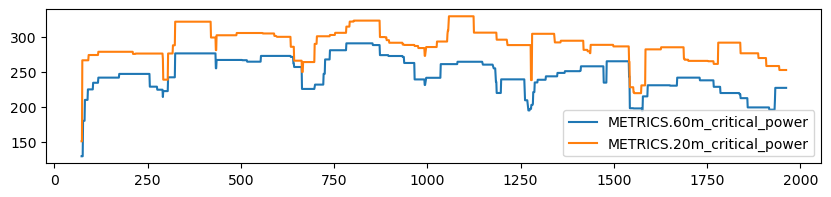

In [191]:
l[['METRICS.60m_critical_power','METRICS.20m_critical_power']].rolling(window=60,min_periods=1).max().plot(figsize=(10,2))

In [194]:
l['METRICS.a_coggan_tss'].fillna(0)

73       91.06705
74       15.77101
75       38.02329
76        2.01822
77      175.99090
          ...    
1958      0.00000
1959      0.00000
1960      0.00000
1961    108.51798
1962    100.06901
Name: METRICS.a_coggan_tss, Length: 1654, dtype: float64

In [125]:
type(l['METRICS.skiba_relative_intensity'][75])

list

In [120]:
l[l['METRICS.skiba_relative_intensity'] > .9]

TypeError: '>' not supported between instances of 'list' and 'float'

# Sample Explore

In [ ]:
target_id = "7567ac31-d479-4b25-9538-541ae8085288"

In [ ]:
act_samp = activ_sum[activ_sum['id'] == target_id].copy()

In [ ]:
act_samp.columns.tolist()

In [ ]:
act_samp['athlete_weight'] = act_samp['20m_critical_power']/act_samp['20m_peak_wpk']
act_samp['athlete_weight'] = act_samp['athlete_weight'].ffill().bfill()

In [ ]:
act_samp.set_index('date',inplace=True)

In [ ]:
act_samp[act_samp['sport'] == 'Bike']['20m_critical_power'].rolling(window=90, min_periods=1).max().plot();

In [ ]:
act_samp.plot(kind='scatter',x='workout_time',y='average_hr')

In [ ]:
def calc_vo2(row, max_hr, resting_hr):
    if row['sport'] == 'Bike':
        percent_vo2 = (row['average_hr'] - resting_hr)/(max_hr - resting_hr)
        vo2_estimated = (((row['average_power']/75)*1000)/row['athlete_weight']) / percent_vo2
        # vo2_estimated = row['VO2max_Detected'] ## overide with Garmin VO2 Estimation
    elif row['sport'] == 'Run':
        percent_vo2 = (row['average_hr'] - resting_hr)/(max_hr - resting_hr)
        vo2_estimated = (210/row['average_speed']) / percent_vo2
    else:
        vo2_estimated =  0
    return vo2_estimated

In [ ]:
act_samp['VO2'] = act_samp.apply(lambda row: calc_vo2(row, 179, 45), axis=1)

In [ ]:
act_samp

# Modeling

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 2)
        self.fc3 = nn.Linear(2, 1)
         
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    
net = NN()
print(net)